In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import sys
sys.path.append('../')
from src import data

from netneurotools import metrics 
from scipy import stats

import mne

%matplotlib widget

!date -I

2024-02-13


## Load data

### Load pytepfit data

In [2]:
empirical = np.load('../data/external/pytepfit/source_estimates/empirical.npz')
empirical['ts'].shape

(400, 200)

In [3]:
empirical['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

In [4]:
empirical['labels'].shape

(200,)

In [5]:
empirical['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

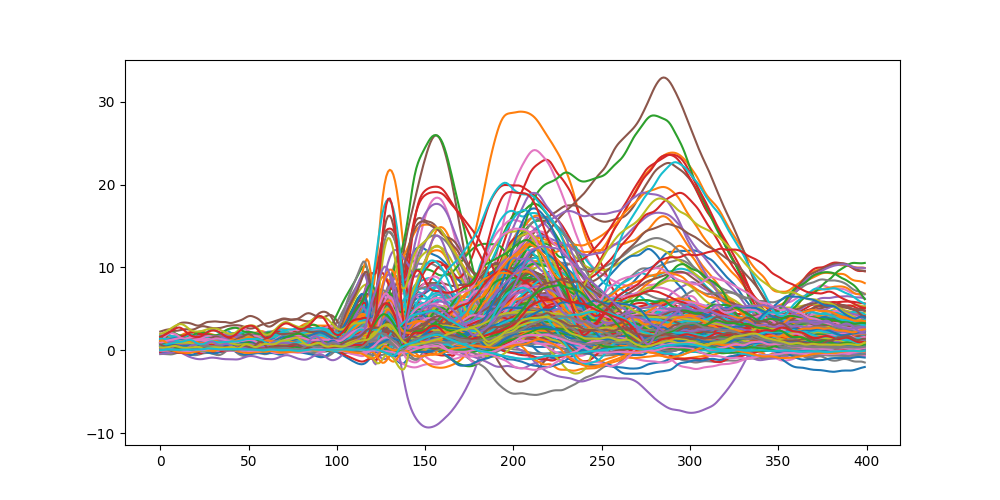

In [6]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(empirical['ts']);
plt.show()

In [7]:
corrected = mne.baseline.rescale(empirical['ts'], np.array([i for i in range(400)]), (0,80))
# když tady dám rovnou mode= 'zscore', tak to nikde není > 5
corrected.shape

Applying baseline correction (mode: mean)


(400, 200)

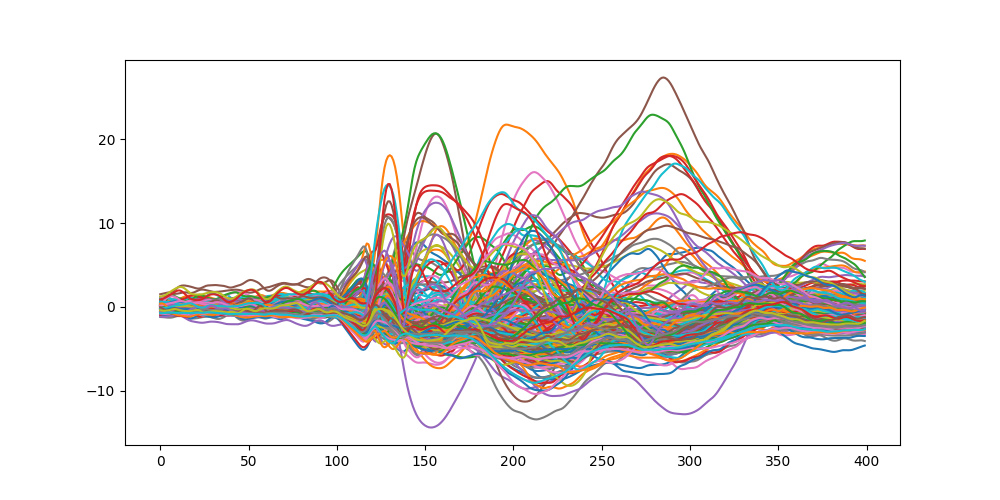

In [8]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(corrected)
plt.show()

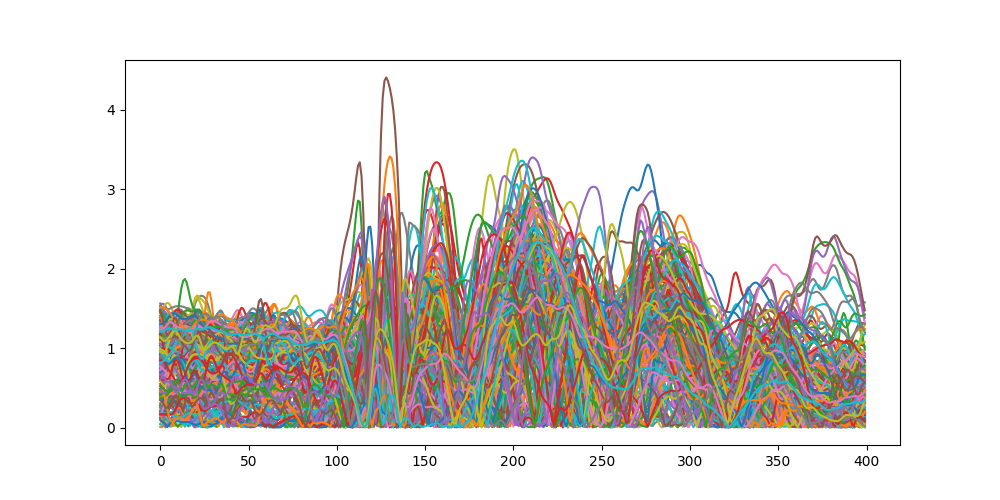

In [30]:
corrected = abs(stats.zscore(corrected,axis=0))

plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(corrected)
plt.show()

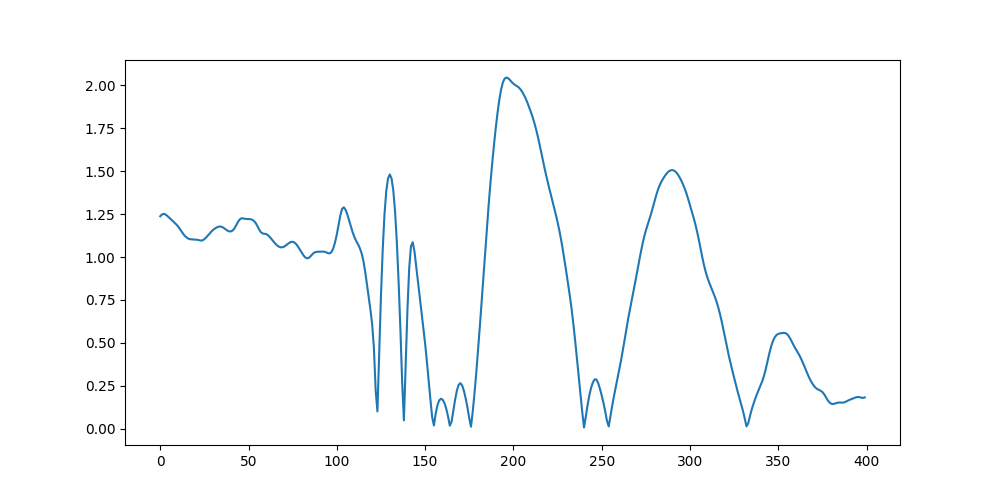

In [31]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(corrected[:,1])
plt.show()

In [32]:
def get_amplitude_first_peak(seqence, threshold):
    id_above_threshold = None
    for i,val in enumerate(seqence):
        if val > threshold:
            id_above_threshold = i
            break

    if id_above_threshold is None:
        return None

    max_value_above_threshold = seqence[id_above_threshold]
    while seqence[id_above_threshold] > threshold:
        if seqence[id_above_threshold] > max_value_above_threshold:
            max_value_above_threshold = seqence[id_above_threshold]
        id_above_threshold += 1
    
    return max_value_above_threshold


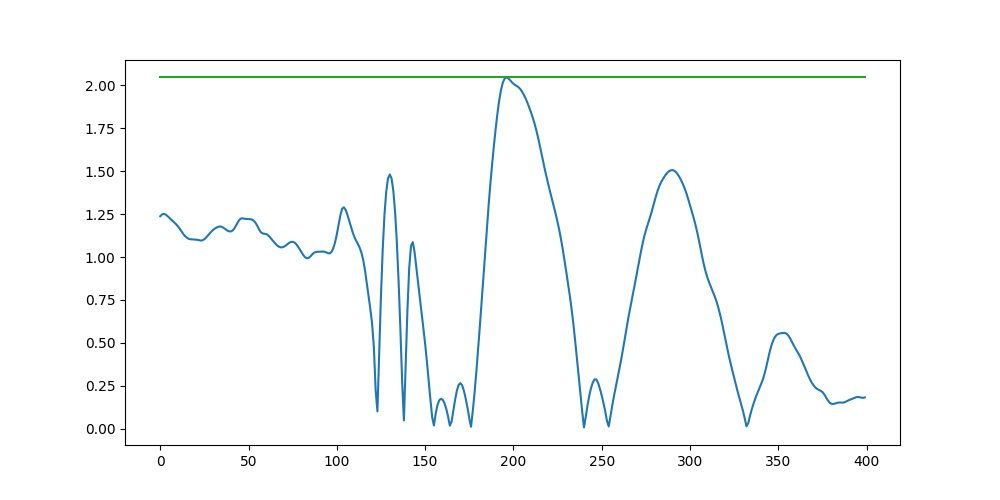

In [33]:
amp = get_amplitude_first_peak(corrected[:,1],10)

plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(corrected[:,1])
plt.plot([amp]*400)
plt.plot([np.max(corrected[:,1])]*400)
plt.show()

In [34]:
responses = {} # threshold:response 01
amplitudes = {}
amplitudes_highest = {}

for threshold in range(2,5):
    maxima = np.max(corrected,axis=0)

    responses[threshold] = maxima > threshold
    amplitudes[threshold] = np.array([get_amplitude_first_peak(corrected[:,i],threshold) for i in range(200)],dtype=float)
    
    amplitudes_highest[threshold] = np.where(responses[threshold], maxima,np.nan)

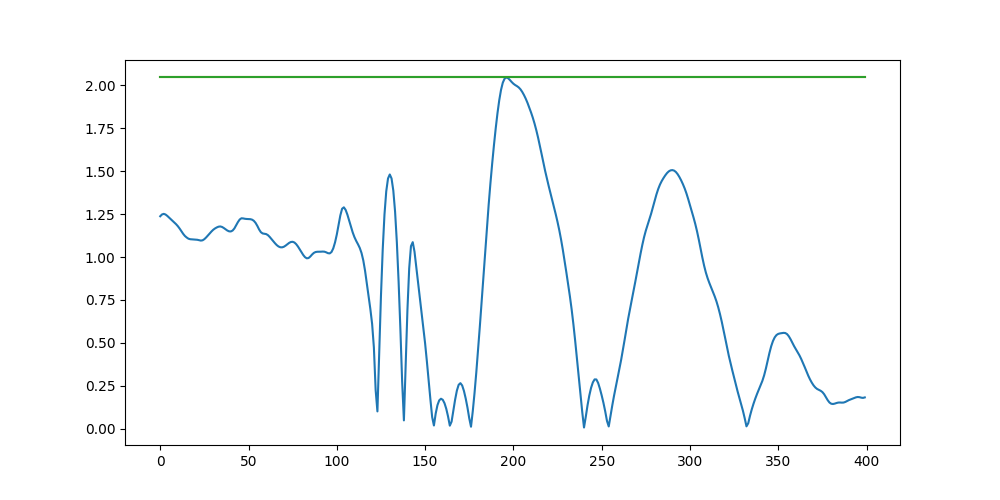

In [37]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.figure()
plt.plot(corrected[:,1])
plt.plot([amplitudes[2][1]]*400)
plt.plot([amplitudes_highest[2][1]]*400)
plt.show()

/tmp/ipykernel_9630/257647548.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3,1, figsize=(len(code) * pixel_per_bar / dpi, 4), dpi=dpi, tight_layout=True)


Text(0.5, 1.0, 'Amplitude highest (threshold 2)')

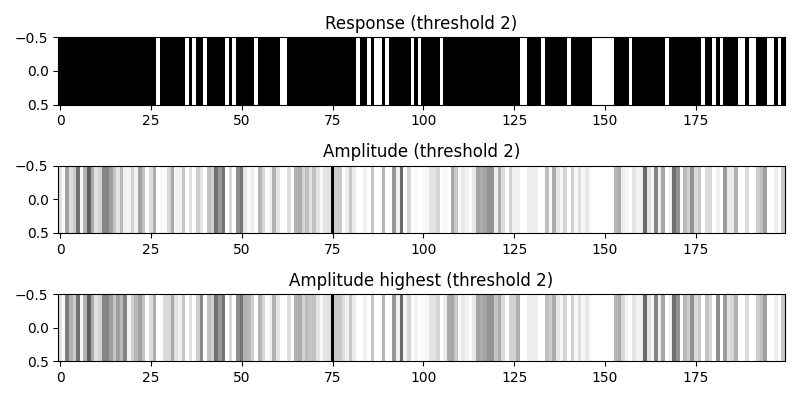

In [40]:
idx = 2

code = np.array(responses[idx])
pixel_per_bar = 4
dpi = 100

fig, axs = plt.subplots(3,1, figsize=(len(code) * pixel_per_bar / dpi, 4), dpi=dpi, tight_layout=True)
axs[0].imshow(code.reshape(1, -1), cmap='binary', aspect='auto',
          interpolation='nearest')
axs[0].set_title(f"Response (threshold {idx})")
axs[1].imshow(amplitudes[idx].reshape(1, -1), cmap='binary', aspect='auto',
          interpolation='nearest')
axs[1].set_title(f"Amplitude (threshold {idx})")
axs[2].imshow(amplitudes_highest[idx].reshape(1, -1), cmap='binary', aspect='auto',
          interpolation='nearest')
axs[2].set_title(f"Amplitude highest (threshold {idx})")

22


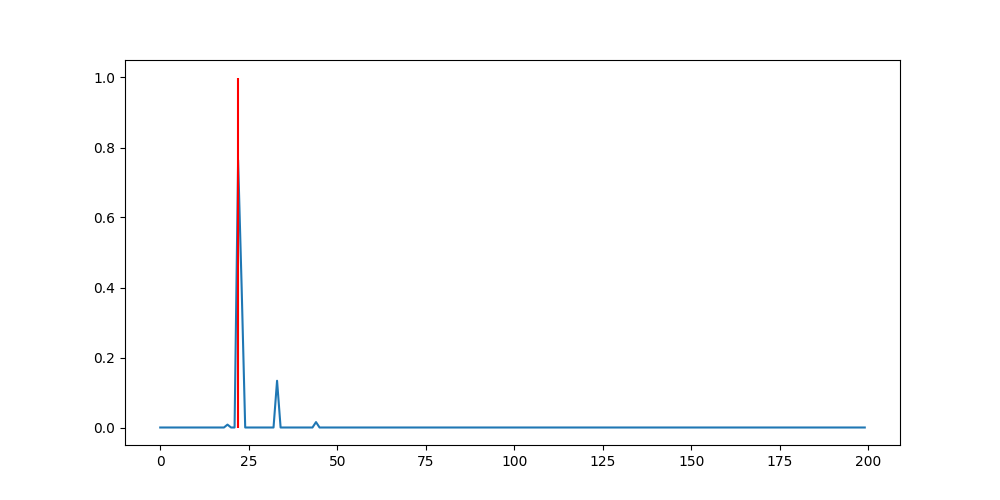

In [41]:
stim_weights = np.load('../data/external/pytepfit/stim_weights.npy')
stim_locatin = np.argmax(stim_weights)
print(stim_locatin)

plt.figure()
plt.plot(stim_weights)
plt.vlines(stim_locatin,0,1,colors='r')
plt.show()

### Load structural (and functional) connectivity data

ne domhof, ty parcelace jsou jiné

In [42]:
SC_W, SC_L, FC = data.load_pytepfit_sc()

SC_W = np.where(SC_W == 0,np.nan,SC_W)
SC_L = np.where(SC_L == 0,np.nan,SC_L)

Text(0.5, 1.0, 'Structural connectivity - lengths (log)')

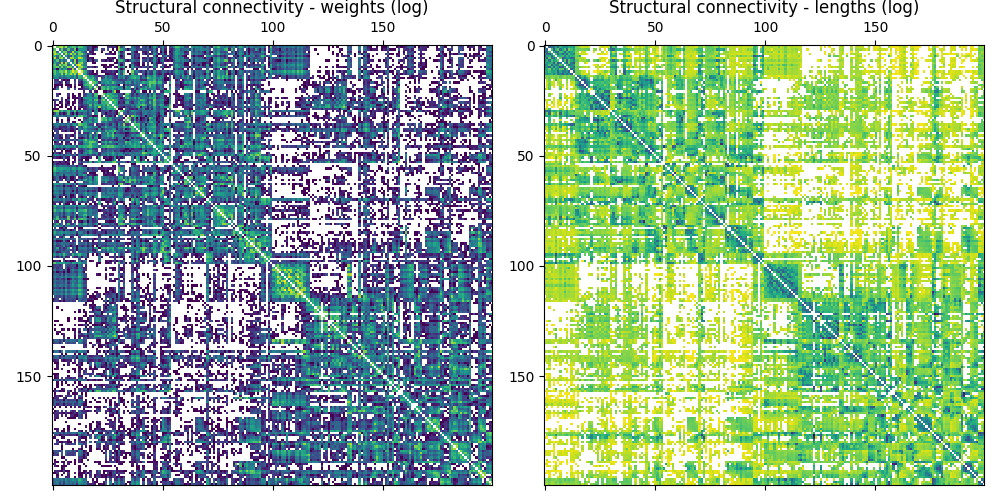

In [43]:
plt.rcParams['figure.figsize'] = [10, 5]

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].matshow(np.log(SC_W))
axs[0].set_title("Structural connectivity - weights (log)")
axs[1].matshow(np.log(SC_L))
axs[1].set_title("Structural connectivity - lengths (log)")

Text(0.5, 1.0, 'ROI distances')

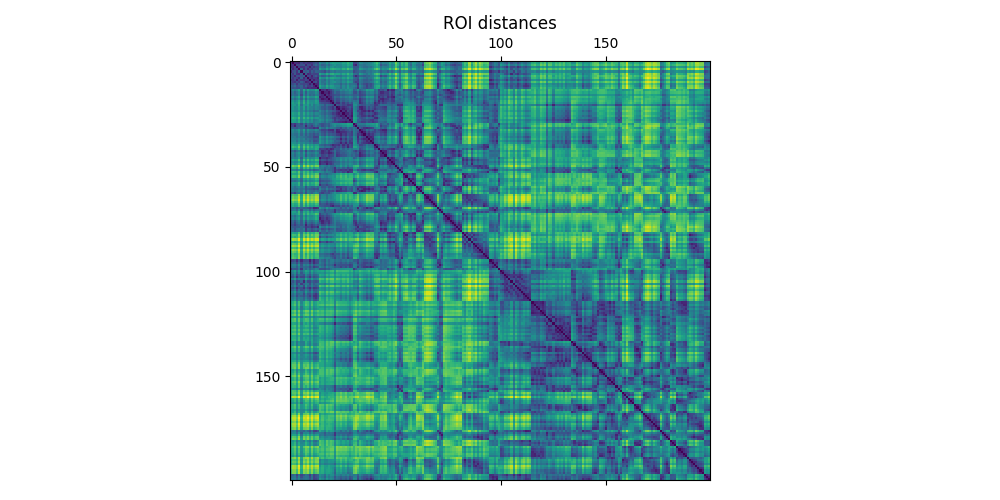

In [44]:
ED = data.schaefer_roi_distances(200)

fig, axs = plt.subplots(1, 1, tight_layout=True)
axs.matshow(ED)
axs.set_title("ROI distances")

Text(0.5, 1.0, 'SC L')

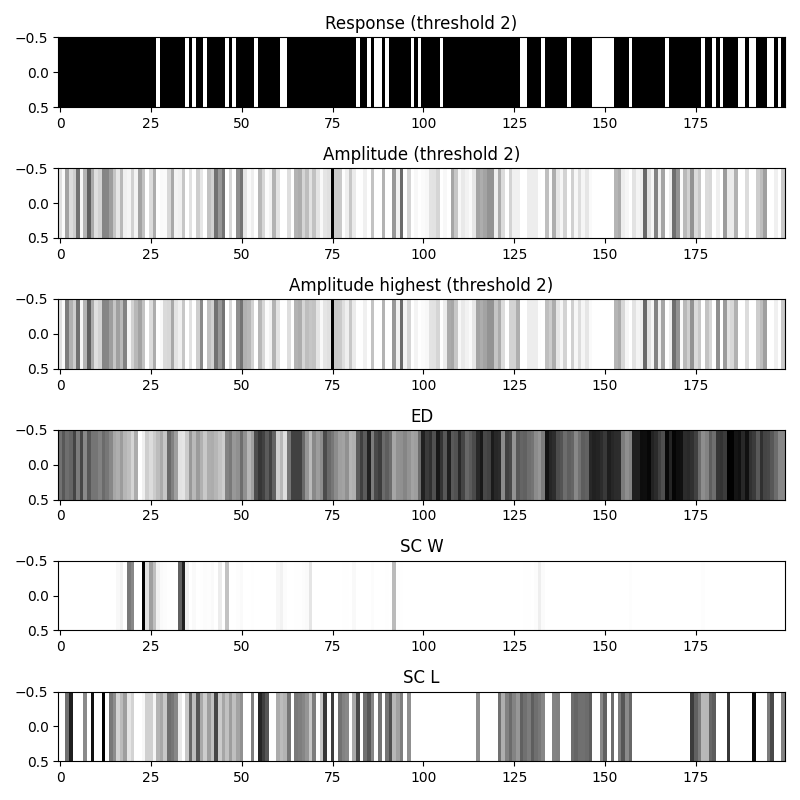

In [45]:
idx = 2

code = np.array(responses[idx])
pixel_per_bar = 4
dpi = 100

fig, axs = plt.subplots(6,1, figsize=(len(code) * pixel_per_bar / dpi, 8), dpi=dpi, tight_layout=True)
axs[0].imshow(code.reshape(1, -1), cmap='binary', aspect='auto',
          interpolation='nearest')
axs[0].set_title(f"Response (threshold {idx})")
axs[1].imshow(amplitudes[idx].reshape(1, -1), cmap='binary', aspect='auto',
          interpolation='nearest')
axs[1].set_title(f"Amplitude (threshold {idx})")
axs[2].imshow(amplitudes_highest[idx].reshape(1, -1), cmap='binary', aspect='auto',
          interpolation='nearest')
axs[2].set_title(f"Amplitude highest (threshold {idx})")

axs[3].imshow(ED[stim_locatin].reshape(1, -1), cmap='binary', aspect='auto',
          interpolation='nearest')
axs[3].set_title(f"ED")
axs[4].imshow(SC_W[stim_locatin].reshape(1, -1), cmap='binary', aspect='auto',
          interpolation='nearest')
axs[4].set_title(f"SC W")
axs[5].imshow(SC_L[stim_locatin].reshape(1, -1), cmap='binary', aspect='auto',
          interpolation='nearest')
axs[5].set_title(f"SC L")

## Correlations

In [79]:
PLOT = False

In [80]:
# shortcut for correlation of X with response probability and amplitude 
def coor_with_response(X):
    for threshold in range(2,5):
        print(f"------------- THRESHOLD {threshold} -------------")

        if responses[threshold].sum() < 3:
            print("Not enough responses")
            break

        rpf = responses[threshold]
        raf = amplitudes[threshold]
        rah = amplitudes_highest[threshold]

        r_probability = spearmanr(X[stim_locatin],rpf,nan_policy='omit')
        r_amplitude = spearmanr(X[stim_locatin],raf,nan_policy='omit')
        r_amp_highest = spearmanr(X[stim_locatin],rah,nan_policy='omit')

        print(f"Correlation with response probabilty: {r_probability.statistic:.3f} (p={r_probability.pvalue:.3f})")
        print(f"Correlation with response amplitude: {r_amplitude.statistic:.3f} (p={r_amplitude.pvalue:.3f})")
        print(f"Correlation with response amplitude (h): {r_amp_highest.statistic:.3f} (p={r_amp_highest.pvalue:.3f})")


In [81]:
coor_with_response(ED)

------------- THRESHOLD 2 -------------
Correlation with response probabilty: -0.068 (p=0.341)
Correlation with response amplitude: 0.024 (p=0.767)
Correlation with response amplitude (h): -0.040 (p=0.612)
------------- THRESHOLD 3 -------------
Correlation with response probabilty: 0.020 (p=0.781)
Correlation with response amplitude: -0.235 (p=0.305)
Correlation with response amplitude (h): -0.223 (p=0.330)
------------- THRESHOLD 4 -------------
Not enough responses


In [82]:
coor_with_response(SC_W) 

------------- THRESHOLD 2 -------------
Correlation with response probabilty: -0.060 (p=0.526)
Correlation with response amplitude: -0.046 (p=0.666)
Correlation with response amplitude (h): -0.032 (p=0.765)
------------- THRESHOLD 3 -------------
Correlation with response probabilty: -0.038 (p=0.687)
Correlation with response amplitude: -0.284 (p=0.398)
Correlation with response amplitude (h): 0.018 (p=0.957)
------------- THRESHOLD 4 -------------
Not enough responses


In [83]:
coor_with_response(SC_L) 

------------- THRESHOLD 2 -------------
Correlation with response probabilty: -0.025 (p=0.796)
Correlation with response amplitude: 0.070 (p=0.513)
Correlation with response amplitude (h): -0.032 (p=0.765)
------------- THRESHOLD 3 -------------
Correlation with response probabilty: 0.097 (p=0.307)
Correlation with response amplitude: 0.155 (p=0.650)
Correlation with response amplitude (h): 0.100 (p=0.770)
------------- THRESHOLD 4 -------------
Not enough responses


In [84]:
# shortest path efficiency
shorest_paths,_ = metrics.distance_wei_floyd(SC_L)
shorest_path_eff = np.divide(1,shorest_paths)

if PLOT:
    plt.matshow(shorest_path_eff)

coor_with_response(shorest_path_eff)

------------- THRESHOLD 2 -------------
Correlation with response probabilty: 0.008 (p=0.913)
Correlation with response amplitude: -0.013 (p=0.866)
Correlation with response amplitude (h): 0.066 (p=0.406)
------------- THRESHOLD 3 -------------
Correlation with response probabilty: -0.022 (p=0.755)
Correlation with response amplitude: 0.057 (p=0.806)
Correlation with response amplitude (h): 0.073 (p=0.754)
------------- THRESHOLD 4 -------------
Not enough responses


/tmp/ipykernel_9630/3541793006.py:3: RuntimeWarning: divide by zero encountered in divide
  shorest_path_eff = np.divide(1,shorest_paths)


In [89]:
com = metrics.communicability_wei(SC_W)
coor_with_response(com)

ValueError: cannot convert float NaN to integer

In [88]:
SI = metrics.search_information(SC_W,ED) # má tu být ED?

if PLOT:
    plt.matshow(SI)

coor_with_response(SI)

UnboundLocalError: local variable 'path' referenced before assignment

In [87]:
# https://netneurolab.github.io/netneurotools/_modules/netneurotools/metrics.html#diffusion_efficiency
diffusion = metrics.diffusion_efficiency(SC_W)[1] # tahle funkce určitě má dostat SC, a ne délky L

if PLOT:
    plt.matshow(diffusion)

coor_with_response(diffusion)

LinAlgError: Array must not contain infs or NaNs

In [86]:
# tady té funkci možná dávám špatný vstup?
_,_,nav_paths,_,_ = metrics.navigation_wu(SC_L, SC_W)
nav_eff = np.divide(1,nav_paths)

if PLOT:
    plt.matshow(nav_eff)

coor_with_response(nav_eff)

------------- THRESHOLD 2 -------------
Correlation with response probabilty: 0.075 (p=0.302)
Correlation with response amplitude: 0.271 (p=0.001)
Correlation with response amplitude (h): 0.264 (p=0.001)
------------- THRESHOLD 3 -------------
Correlation with response probabilty: 0.209 (p=0.004)
Correlation with response amplitude: 0.098 (p=0.700)
Correlation with response amplitude (h): 0.288 (p=0.247)
------------- THRESHOLD 4 -------------
Not enough responses


/tmp/ipykernel_9630/3036424556.py:3: RuntimeWarning: divide by zero encountered in divide
  nav_eff = np.divide(1,nav_paths)
